In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('/content/train.csv')

In [51]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

#Data Cleaning
The data which is obtained from the primary sources is termed the raw data and required a lot of preprocessing before we can derive any conclusions from it or to some modeling on it. Those preprocessing steps are known as data cleaning and it includes, outliers removal, null value imputation, and removing discrepancies of any sort in the data inputs.

In [53]:
df['ethnicity'].value_counts()

ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: count, dtype: int64

In the above two outputs we can observe some ambiguity that there are ‘?’, ‘others’, and ‘Others’ which all must be the same as they are unknown or we can say that null values have been substituted with some indicator.

In [54]:
df['relation'].value_counts()

relation
Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: count, dtype: int64

The same is the case with this column so, let’s clean this data, and along with this let’s convert ‘yes’ and ‘no’ to 0 and 1

In [55]:
df= df.replace({ 'yes':1, 'no':0, '?':'others','others':'Others'})

#Exploratory Data Analysis
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. Here we will see how to check the data imbalance and skewness of the data.

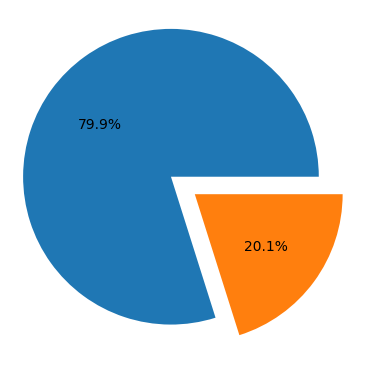

In [56]:
plt.pie(df['Class/ASD'].value_counts().values, autopct='%1.1f%%',explode=[0.2,0])
plt.show()

The dataset we have is highly imbalanced. If we will train our model using this data then the model will face a hard time predicting the positive class which is our main objective here to predict whether a person has autism or not with high accuracy.

In [57]:
ints = []
objects = []
floats = []

for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == object:
    objects.append(col)
  else:
    floats.append(col)

In [58]:
ints

['ID',
 'A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'jaundice',
 'austim',
 'used_app_before',
 'Class/ASD']

In [59]:
floats

['age', 'result']

In [60]:
ints.remove('ID')
ints.remove('Class/ASD')

ValueError: num must be an integer with 1 <= num <= 12, not 13

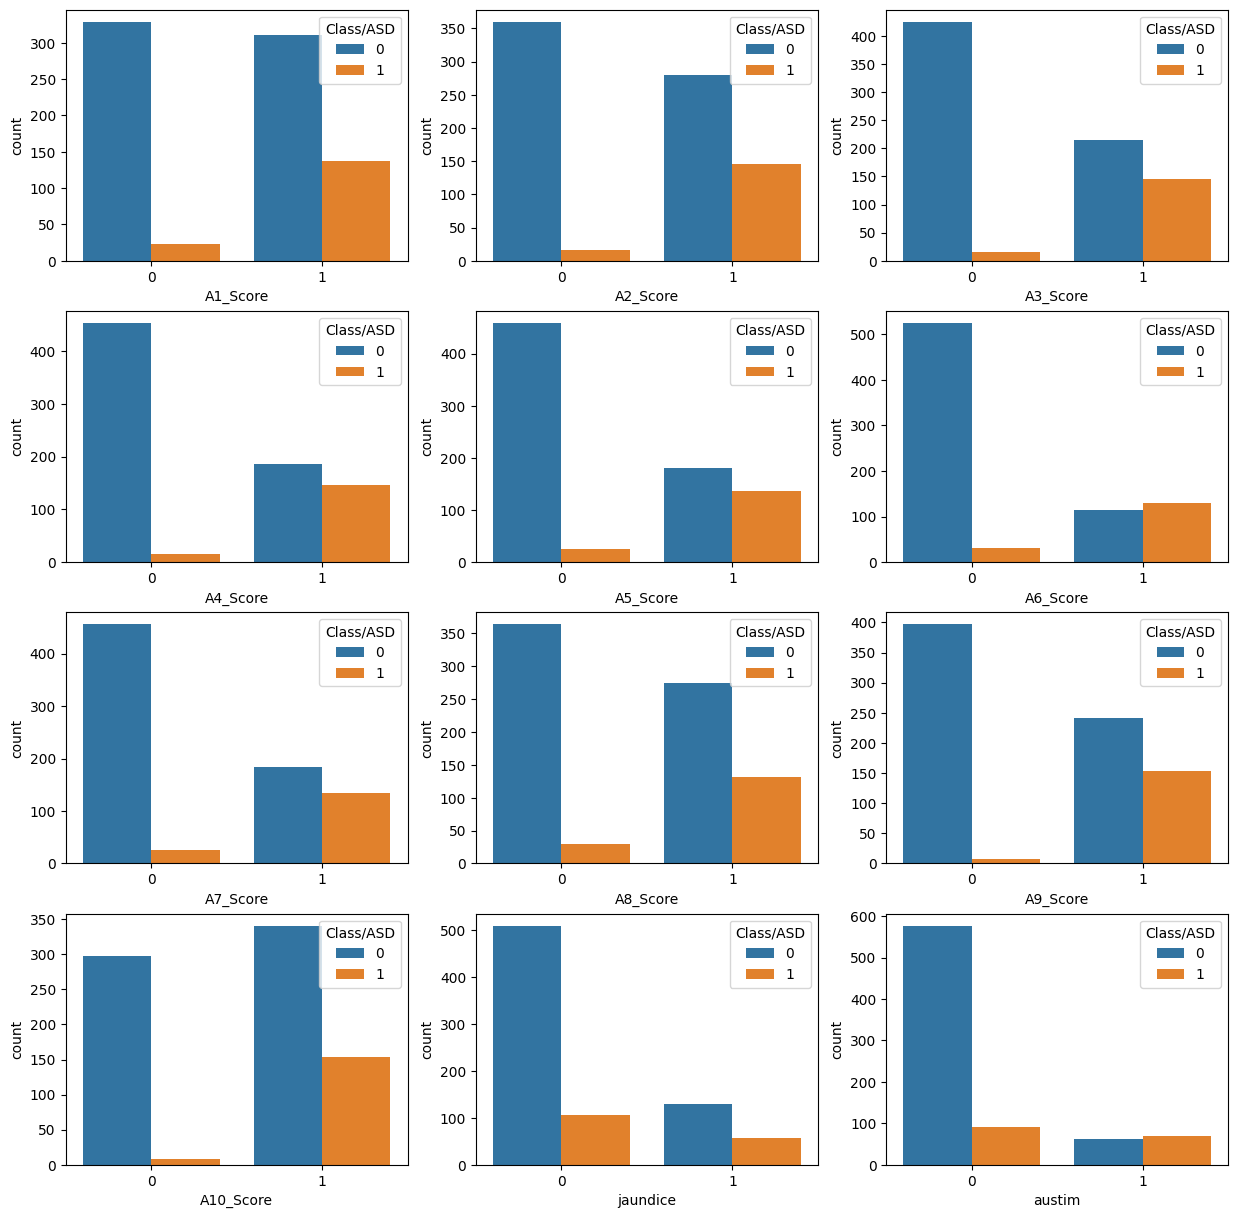

In [75]:
plt.subplots(figsize=(15,15))

for i, col in enumerate(ints):
   plt.subplot(4,3,i+1)
   sns.countplot(data=df,x= col, hue='Class/ASD')
plt.tight_layout()
plt.show()


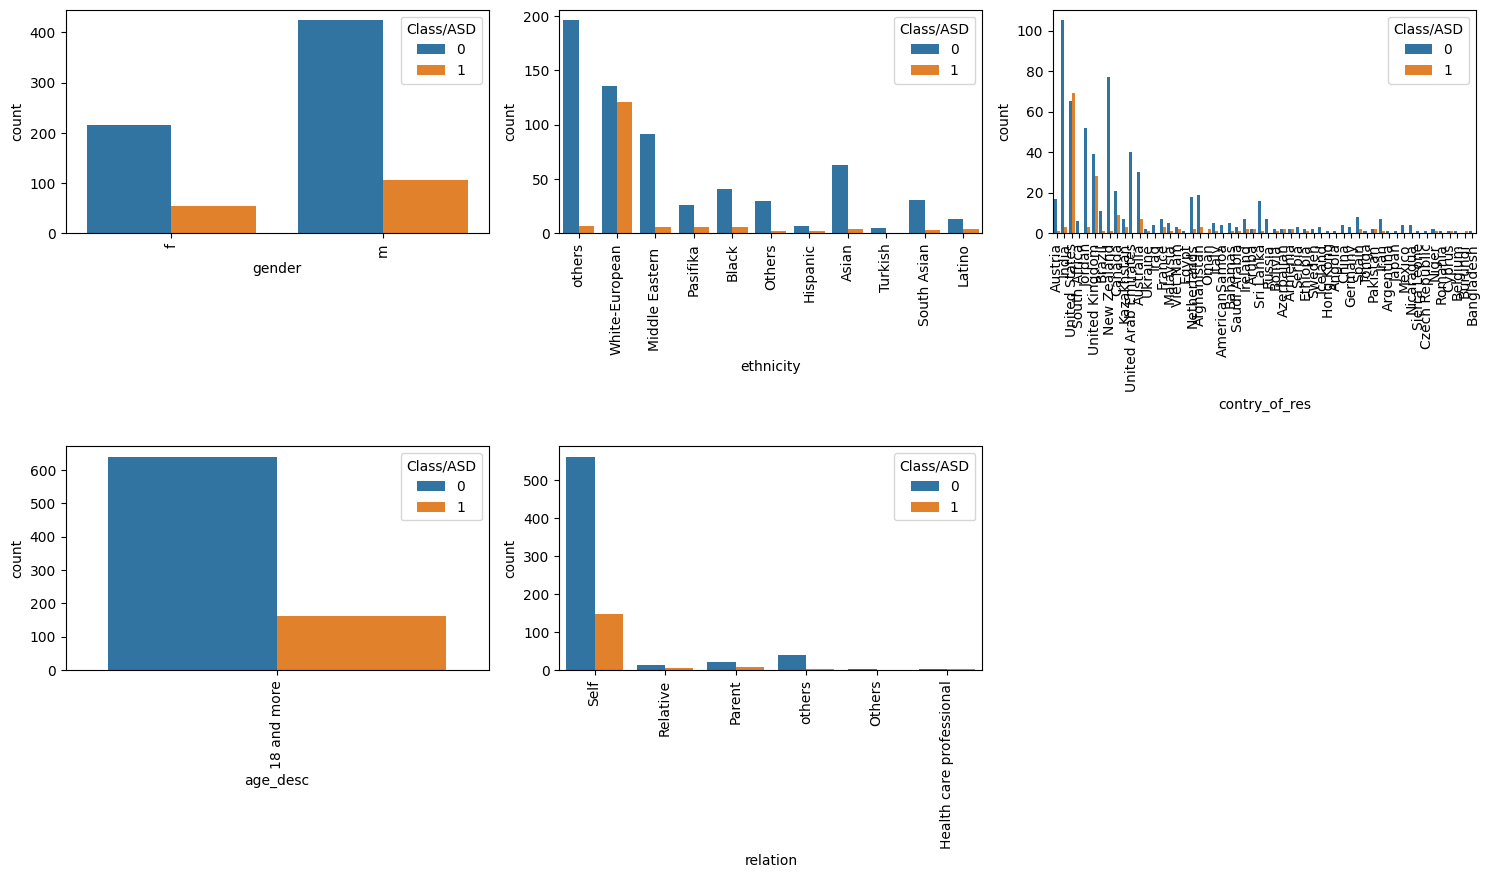

In [92]:
plt.figure(figsize=(15,20))

for i, col in enumerate(objects):
   plt.subplot(5,3,i+1)
   sns.countplot(data=df,x= col, hue='Class/ASD')
   plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

From the above plots we can draw the following observations:

Age_desc is the same for all the data points.
This used_app_before feature doesn’t seem to be useful or it will be the source of data leakage.
Here it seems like the chances of a male having autism is higher than a female but that is not true because we don’t have an equal number of examples of males and females

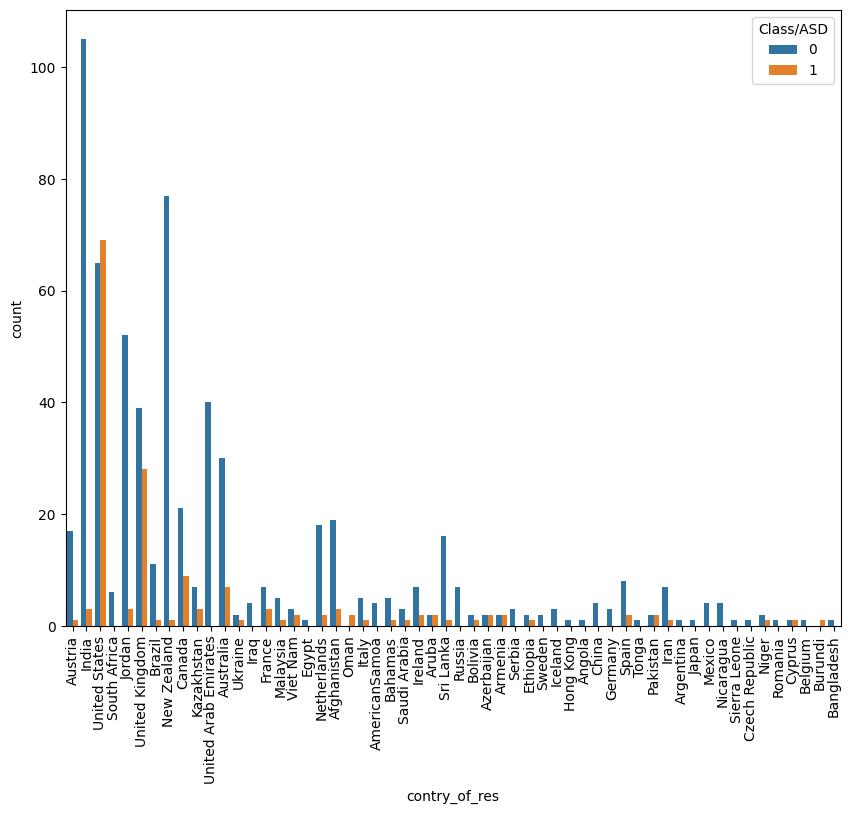

In [87]:
plt.figure(figsize=(10,8))
sns.countplot(data=df, x='contry_of_res', hue='Class/ASD')
plt.xticks(rotation=90)
plt.show()

In some places approximately 50% of the data available for that country have autism and in some places, this is quite low. This implies that the geography of a person also gives an idea of having autism.

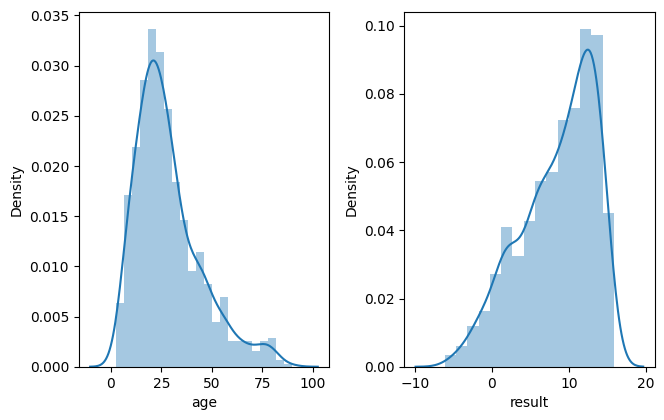

In [97]:
plt.figure(figsize=(10,8))

for i, col in enumerate(floats):
   plt.subplot(2,3,i+1)
   sns.distplot(df[col])
plt.tight_layout()
plt.show()

Both of the continuous data are skewed left one is positive and the right one is negatively skewed.

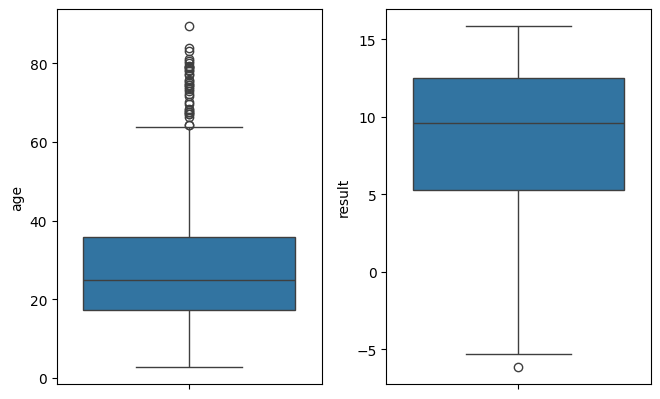

In [98]:
plt.figure(figsize=(10,8))

for i, col in enumerate(floats):
   plt.subplot(2,3,i+1)
   sns.boxplot(df[col])
plt.tight_layout()
plt.show()

some outliers in the result column. Let’s remove that as it doesn’t seem like too much loss of information

In [100]:
df = df[df['result']>-5]
df.shape
#here we lost only two data points.

(798, 22)

#Feature Engineering
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [101]:
# This functions make groups by taking
# the age as a parameter
def convertAge(age):
	if age < 4:
		return 'Toddler'
	elif age < 12:
		return 'Kid'
	elif age < 18:
		return 'Teenager'
	elif age < 40:
		return 'Young'
	else:
		return 'Senior'

df['ageGroup'] = df['age'].apply(convertAge)


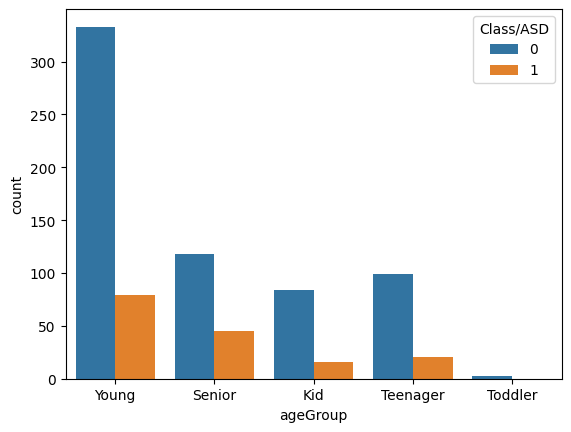

In [105]:
sns.countplot(data=df, x='ageGroup',hue='Class/ASD')
plt.show()

Here we can conclude that the Young and Toddler group of people have lower chances of having Autism.

In [108]:
def add_feature(data):

# Creating a column with all values zero
    data['sum_score'] = 0
    for col in data.loc[:,'A1_Score':'A10_Score'].columns:

	  # Updating the 'sum_score' value with scores
   	# from A1 to A10
	      data['sum_score'] += data[col]

    # Creating a random data using the below three columns
    data['ind'] = data['austim'] + data['used_app_before'] + data['jaundice']

    return data

df = add_feature(df)


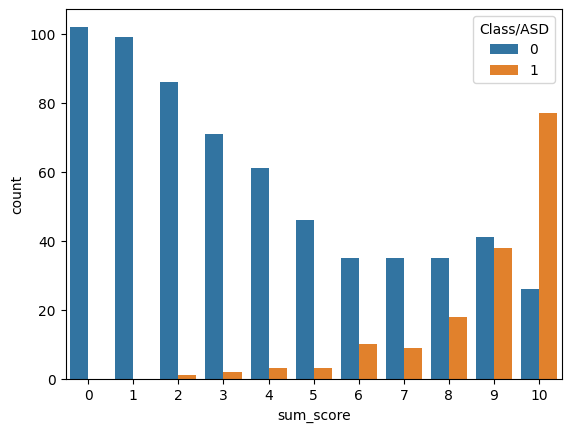

In [110]:
sns.countplot(x=df['sum_score'], hue=df['Class/ASD'])
plt.show()


Another amazing observation higher the sum score higher the chances of having autism is higher as well and similarly for lower sum scores that are for less than 5 it is rare that the person has autism.

In [111]:
# Applying log transformations to remove the skewness of the data.
df['age'] = df['age'].apply(lambda x: np.log(x))


The age data given to us is positively skewed. As we know that skewed data impacts the performance of the model, we will apply log transformations to remove the skewness of the data.

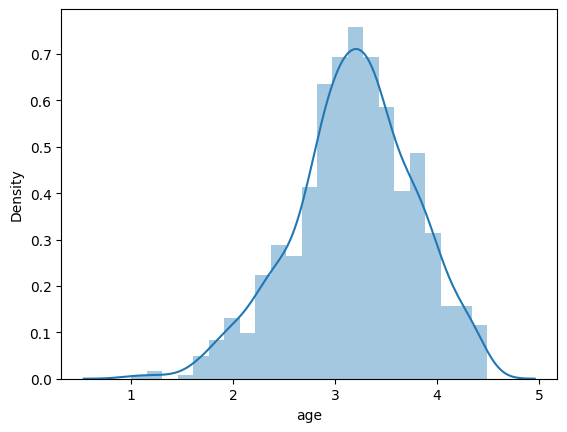

In [113]:
sns.distplot(df['age'])
plt.show()


the skewness of the data has been removed successfully by using the log transformations.

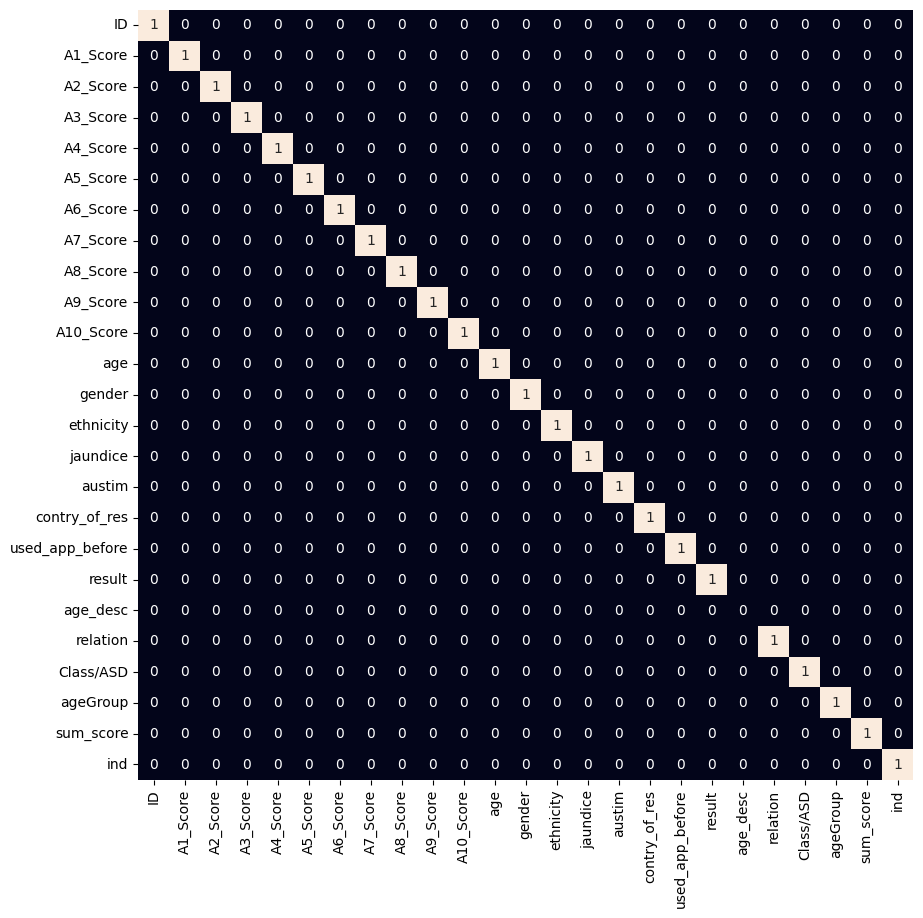

In [116]:
def encode_labels(data):
	for col in data.columns:

  	# Here we will check if datatype
  	# is object then we will encode it
	  if data[col].dtype == 'object':
		  le = LabelEncoder()
		  data[col] = le.fit_transform(data[col])

	return data

df = encode_labels(df)

# Making a heatmap to visualize the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()


#Model Training
Now we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [117]:
removal = ['ID', 'age_desc', 'used_app_before', 'austim']
features = df.drop(removal + ['Class/ASD'], axis=1)
target = df['Class/ASD']


Let’s split the data into training and validation data. Also, the data was imbalanced earlier now we will balance it using the Random Over Sampler in this method we sample some points from the minority class and repeat it multiple times so, that the two classes get balanced.

In [119]:
from imblearn.over_sampling import RandomOverSampler

In [120]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.2, random_state=10)

# As the data was highly imbalanced we will balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, Y = ros.fit_resample(X_train,Y_train)
X.shape, Y.shape


((1026, 20), (1026,))

 let’s normalize the data to obtain stable and fast training.

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


let’s train some state-of-the-art machine learning models and compare them which fit better with our data.

In [125]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for model in models:
    model.fit(X, Y)

print(f'{model} : ')
print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
print()


SVC() : 
Training Accuracy :  0.9405458089668616
Validation Accuracy :  0.8082437275985663



#Model Evaluation
From the above accuracies, we can say that Logistic Regression and SVC() classifier perform better on the validation data with less difference between the validation and training data. Let’s plot the confusion matrix as well for the validation data using the Logistic Regression model.

In [132]:
from sklearn.metrics import confusion_matrix

In [140]:
metrics.confusion_matrix(Y,model.predict(X))



array([[453,  60],
       [  1, 512]])